<a href="https://colab.research.google.com/github/AbelGPenas/Curiosity-Box/blob/main/PowerOfMissingValues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
%cd /content/drive/MyDrive/Projects/Kaggle/DS_HR

/content/drive/MyDrive/Projects/Kaggle/DS_HR


Info about the dataset can be found in https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

# A. Notebook setup

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly
import plotly.graph_objects as go
pio.renderers.default = 'colab'
import plotly.express as px
import itertools
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV,cross_val_predict

In [36]:
df = pd.read_csv(filepath_or_buffer='aug_train.csv')
df_0 = df.loc[df['target']==0]
df_1 = df.loc[df['target']==1]

## Dataset description

As it can be seen, most of the columns in the dataset are categorical, witha  mixture of ordinal and not ordinal categories.

In [37]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


The degree of cardinality of the categorical classes presents as well a high degree of variability. In the caount column we can foresee as well a relevant amount of missing values.

In [38]:
df.describe(include='object').transpose()

,count,unique,top,freq
city,19158,123,city_103,4355
gender,14650,3,Male,13221
relevent_experience,19158,2,Has relevent experience,13792
enrolled_university,18772,3,no_enrollment,13817
education_level,18698,5,Graduate,11598
major_discipline,16345,6,STEM,14492
experience,19093,22,>20,3286
company_size,13220,8,50-99,3083
company_type,13018,6,Pvt Ltd,9817
last_new_job,18735,6,1,8040


Enrollee_ID seems purely an indexing column, so it will not be included in the analysis. The other 2 numerical columns present a tailed distribution, with very different scales. On the good news side, there are no missing values in these two numerical columns. Same for the dependent binary variable.

In [39]:
df.describe(include=['float64', 'int64']).transpose()

,count,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
city_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


Lets separate the dependent and independent variables in two different dataframes.

In [40]:
target_df = df['target']
df = df.drop(['target'], axis=1)

# B. Preliminary EDA

Let's define a function to provide an overall view of all our variables, trying to understand which variables provide a better separability for the two classes of the target variable.

In [41]:
def EDA_subplot_binary(nrows, ncols, df_0, df_1, columns, categoryOrderDict=dict()):
  '''
  Create a figure with histograms as subplots for a dataframe with binary target variable
  Bars have normalized probability values

  Parameters:
  nrows -- number of subplot rows (no default)
  ncols -- number of subplot columns (no default)
  df_0 -- dataframe for rows with binary target variable with value 0 (no default)
  df_1 -- dataframe for rows with binary target variable with value 1 (no default)
  categoryOrderDict -- dictionary for those graphs that should have an specific x axis order (dict key = column name) (default - empty dict)
  columns -- list of names of the columns to be plotted

  Returns:
  Figure (instance of plotly.graph_objs.Figure)

  '''
  fig = plotly.subplots.make_subplots(rows=nrows, cols=ncols, subplot_titles=columns)
  cartesian_product = itertools.product(list(range(1,nrows+1)), list(range(1,ncols+1)))
  subplot_positions = [tuple for tuple in cartesian_product]

  for pos, column in zip(subplot_positions, columns): #Both dfs should have the same columns
    fig.add_trace(go.Histogram(name='Satisfied workers', x=df_0[column], histnorm='probability'),
                  row= pos[0], col=pos[1])
    fig.add_trace(go.Histogram(name='Job seekers', x=df_1[column], histnorm='probability'),
                  row= pos[0], col=pos[1])
    if column in categoryOrderDict.keys(): #Check if x axis order is specified in categoryOrderDict
      order = categoryOrderDict[column]
      fig.update_xaxes(categoryarray=order, row= pos[0], col=pos[1], tickangle=45)

    else:
      fig.update_xaxes(categoryorder='category ascending', row= pos[0], col=pos[1], tickangle=45)
      
  fig.update_layout(barmode='overlay')
  fig.update_traces(opacity=0.60)
  fig.update_layout(width=1200, height=1000)
  return fig

In [42]:
#Some custom ordering for ordinal variables
catOrderDict = {'education_level': ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd'],
                'enrolled_university': ['no_enrollment', 'Part time course', 'Full time course'],
                'company_size': ['<10','10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']}
#We leave out the enrolled_id column
columns2plot = df_0.columns[1:-1] 
fig = EDA_subplot_binary(3, 4, df_0, df_1, columns2plot, catOrderDict)
fig.show()

Some relevant insights can be already drawn after a visual comparison:


*   Job seekers tend to have less years of experience, and no relevant experience.
*   Job seekers tend to have been enrolled at uni full-time a bit more than data scientists not looking for a job change.
*   In general, data scientists have a graduate title. This trend is higher among job seekers.
*   Geography (city and city development index) seems to be a distinctive feature to classify job seekers and non-job seekers.





# C. Missing data

## Exploration

As said above, there is a relevant amount of missing values for most of the columns:

In [43]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
dtype: int64

From those categories with a larger amount of missing values:
* Gender, Major Discipline and Company type are categories with a clear most frequent category (see EDA before) and similar distribution between job seekers and satisfied workers. Hence an imputation strategy based on replacemnt by most frequent category could be a sensible option.
*  Company size category shows a more balanced distribution, and some differences between job seekers and satisfied workers. Imputing with most freqeunt values is a less sensible option in this case. 
* The amount of missing values in the other categories are of a lower order of magnitude, making them a better target for a dropout strategy (remove rows with missing values).

A more visual evaluation of the between-columns differences in missing values can be seen in the figure below. 

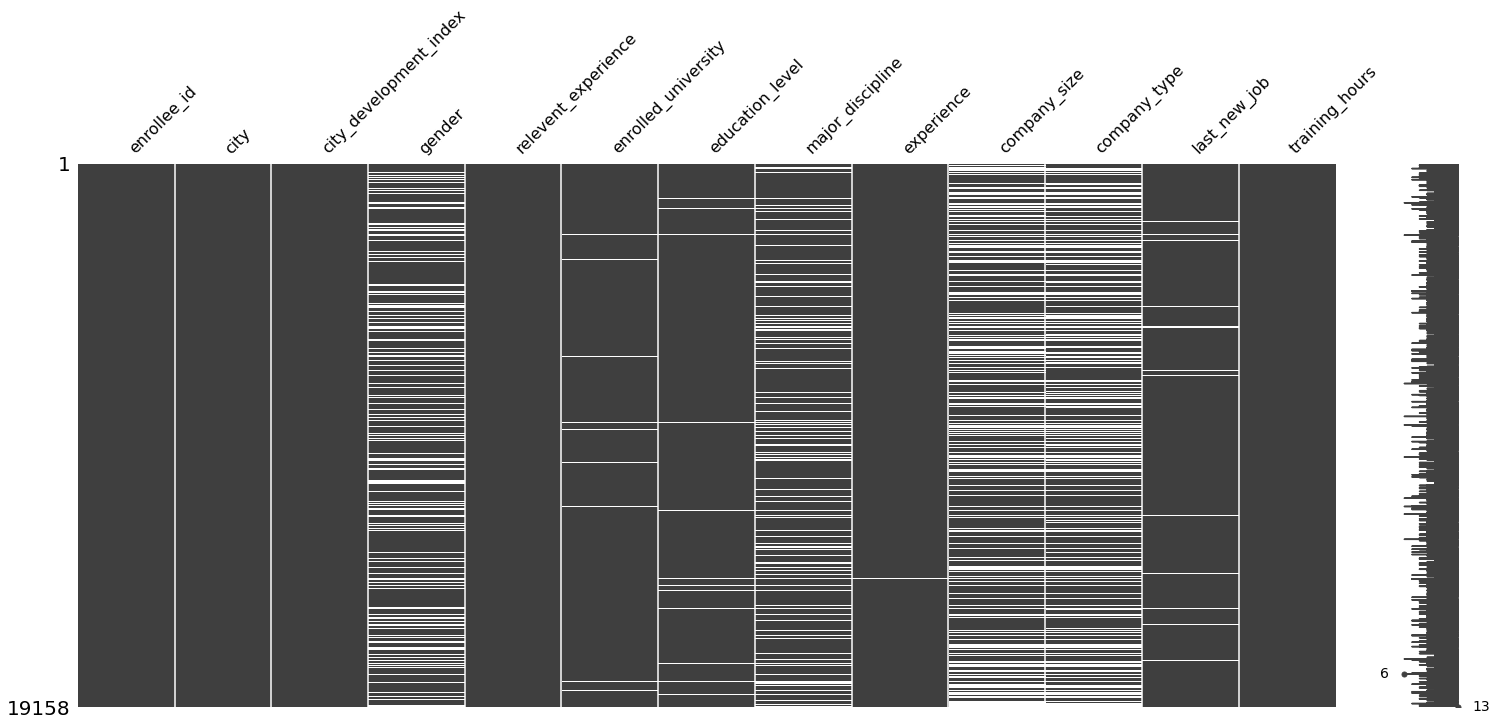

In [44]:
msno.matrix(df)

The correlation between the occurence of the missing values within two columns is visually presented in the heatmap below. This plot can be interpreted as follows:
* A correlation of 1 means that the missing values occur in the same rows.
* A correlation of -1 means that when one of the columns has missing values the second column does not, and viceversa.
* A correlation of 0 means a stochastic relation of the occurence of missing values in the two columns.

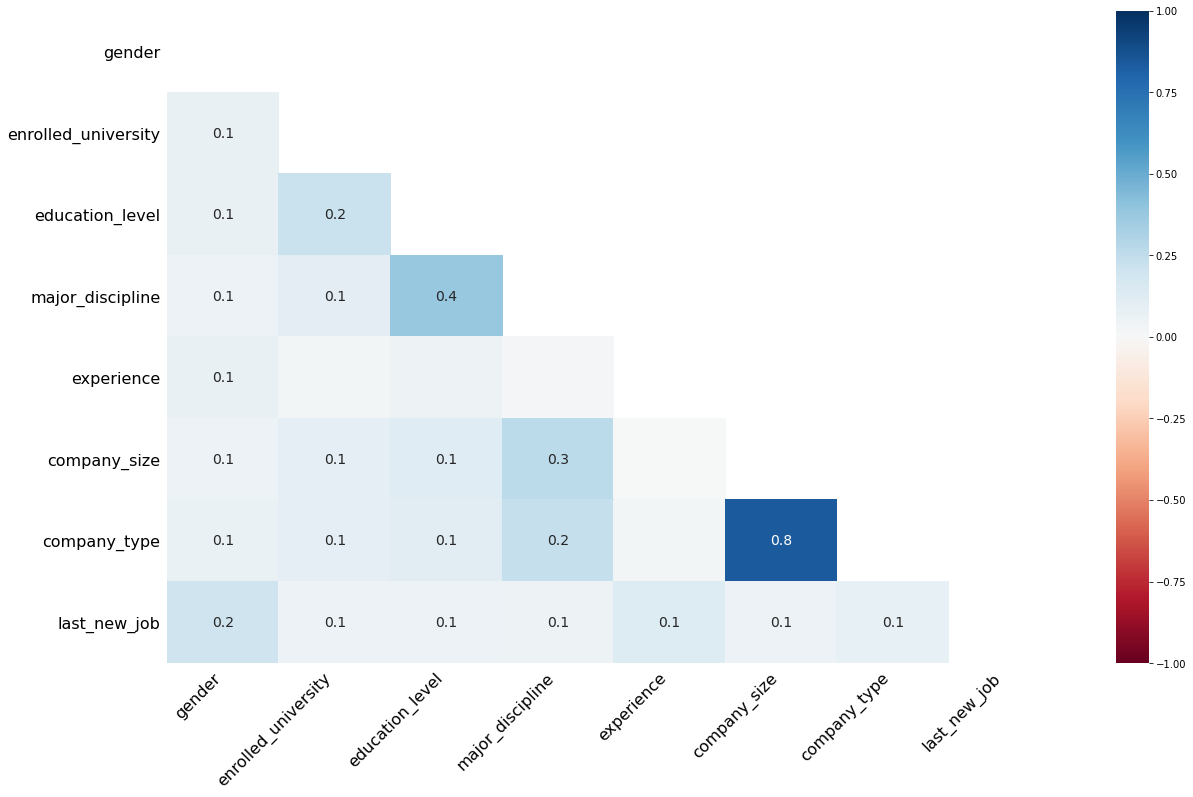

In [45]:
msno.heatmap(df)

Main takes from the heatmap is that there is a strong correlation between the occurence of the missing values in teh company size and company type columns, and some correlation between the educational level and major discipline.

The dendogram below (based on a hierarchical clustering run over the missing values occurence under the hood) provides also a synthetical summary of the similarities between columns for the occurence of missing values. 
* The main factor driving the clustering is the amount of missing values, with the columns effectively sorted from left to right in decreasing order of missing values. 
* However, it can be seen a relevant similarity again between company size and company type, with gender and major discipline as experiencing unrelated missing values phenomena and the rest of the columns (due to the low amount of missing values) forming a rather homogeneus cluster.

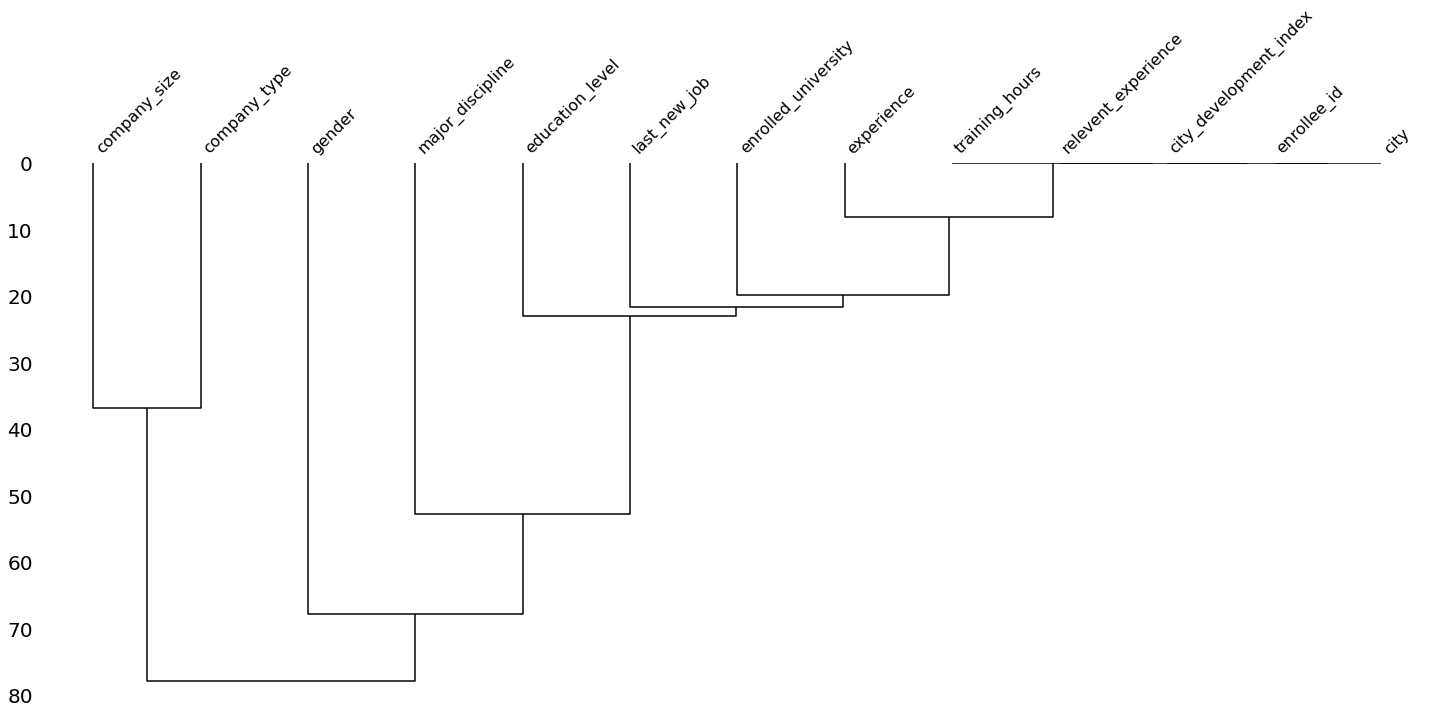

In [46]:
msno.dendrogram(df)

In [47]:
df = df[['education_level', 'experience', 'company_size', 'last_new_job', # Ordinal columns 
              'training_hours', 'city_development_index', # Numerical columns
              'city', #categorical column to be labelled
              'gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']] #Categorical non-ordinal columns

## Strategy 1: NA Drop out

The simplest strategy possible is to naively drop out the observations with NA values. The main drawback of this strategy is that it implies the loss of a lot of information, and might result in a biased dataset.

In [48]:
df_dropout = df.dropna()

In [49]:
df_dropout.shape

(8955, 12)

In this everything but subtle process we have lost almost a 54% of the observations. It will be interesting to see how it works out when using it!

## Strategy 2: Simple Imputation

A more sofisticated option to deal with missing values is to substitute them. THis way,we avoid loosing all the info contained in the non-na rows that were deleted with the dropout strategy. But...what to introduce in their place? Two strategies are common: 
* Replace them by the most common category: This assumes that missing data occurs at random and missing values look like the majority.
* Replace them by a new category: There might be an explaination/bias behind the fact that those values are missing (in other words, they have some hidden factor in common!). Hence, defining a new class common to them all makes a lot of sense.

### 2.1: Imputation with new category

In [50]:
df_newcat = df.fillna(value="missing")

In [51]:
df_newcat.head()

,education_level,experience,company_size,last_new_job,training_hours,city_development_index,city,gender,relevent_experience,enrolled_university,major_discipline,company_type
0,Graduate,>20,missing,1,36,0.920,city_103,Male,Has relevent experience,no_enrollment,STEM,missing
1,Graduate,15,50-99,>4,47,0.776,city_40,Male,No relevent experience,no_enrollment,STEM,Pvt Ltd
2,Graduate,5,missing,never,83,0.624,city_21,missing,No relevent experience,Full time course,STEM,missing
3,Graduate,<1,missing,never,52,0.789,city_115,missing,No relevent experience,missing,Business Degree,Pvt Ltd
4,Masters,>20,50-99,4,8,0.767,city_162,Male,Has relevent experience,no_enrollment,STEM,Funded Startup


### 2.2 Imputation with most frequent value

In [52]:
df_freq = df.fillna(df.mode().iloc[0])

In [53]:
df_freq.head()

,education_level,experience,company_size,last_new_job,training_hours,city_development_index,city,gender,relevent_experience,enrolled_university,major_discipline,company_type
0,Graduate,>20,50-99,1,36,0.920,city_103,Male,Has relevent experience,no_enrollment,STEM,Pvt Ltd
1,Graduate,15,50-99,>4,47,0.776,city_40,Male,No relevent experience,no_enrollment,STEM,Pvt Ltd
2,Graduate,5,50-99,never,83,0.624,city_21,Male,No relevent experience,Full time course,STEM,Pvt Ltd
3,Graduate,<1,50-99,never,52,0.789,city_115,Male,No relevent experience,no_enrollment,Business Degree,Pvt Ltd
4,Masters,>20,50-99,4,8,0.767,city_162,Male,Has relevent experience,no_enrollment,STEM,Funded Startup


## Strategy 3: Advanced imputation - unsupervised classification

A more advanced strategy is to used unsupervised learning to impute the missing values, trying to predict it. One of the most common algorithms for this purpose is K-nearest neighbors.

In [54]:
def custom_encoding(df:pd.DataFrame)->pd.DataFrame:
# Making Dictionaries of ordinal features
  mapping_dict = {
      'gender' : {
          'Female': 2,
          'Male': 1,
          'Other': 0
          },

      'relevent_experience' : {
          'Has relevent experience':  1,
          'No relevent experience':    0
      },

      'enrolled_university' : {
          'no_enrollment'   :  0,
          'Full time course':    2, 
          'Part time course':    1 
      },
          
      'education_level' : {
          'Primary School' :    0,
          'Graduate'       :    2,
          'Masters'        :    3, 
          'High School'    :    1, 
          'Phd'            :    4
          },
          
      'major_discipline' : { 
          'STEM'                   :    0,
          'Business Degree'        :    1, 
          'Arts'                   :    2, 
          'Humanities'             :    3, 
          'No Major'               :    4, 
          'Other'                  :    5 
      },
          
      'experience' : {
          '<1'      :    0,
          '1'       :    1, 
          '2'       :    2, 
          '3'       :    3, 
          '4'       :    4, 
          '5'       :    5,
          '6'       :    6,
          '7'       :    7,
          '8'       :    8, 
          '9'       :    9, 
          '10'      :    10, 
          '11'      :    11,
          '12'      :    12,
          '13'      :    13, 
          '14'      :    14, 
          '15'      :    15, 
          '16'      :    16,
          '17'      :    17,
          '18'      :    18,
          '19'      :    19, 
          '20'      :    20, 
          '>20'     :    21
      },
          
      'company_type' : {
          'Pvt Ltd'               :    0,
          'Funded Startup'        :    1, 
          'Early Stage Startup'   :    2, 
          'Other'                 :    3, 
          'Public Sector'         :    4, 
          'NGO'                   :    5
      },

      'company_size' : {
          '<10'          :    0,
          '10/49'        :    1, 
          '100-500'      :    3, 
          '1000-4999'    :    5, 
          '10000+'       :    7, 
          '50-99'        :    2, 
          '500-999'      :    4, 
          '5000-9999'    :    6
      },
          
      'last_new_job' : {
          'never'        :    0,
          '1'            :    1, 
          '2'            :    2, 
          '3'            :    3, 
          '4'            :    4, 
          '>4'           :    5
      }
  }
  df_pre = df.copy(deep=True)
  # Encode the columns with the custom maps
  for key in mapping_dict.keys():
    df_pre.loc[:,key] = df_pre[key].map(mapping_dict[key])
  ord_en = OrdinalEncoder()
  df_pre.loc[:,'city'] = ord_en.fit_transform(df_pre.loc[:,'city'].values.reshape(-1, 1)) 
  return df_pre

In [55]:
df_pre = custom_encoding(df)
cities_series = df_pre['city']
df_pre_impute = df_pre.loc[:,set(df_pre.columns) - set(["city"])]

In [56]:
df_pre_impute

,relevent_experience,training_hours,major_discipline,company_type,gender,last_new_job,experience,company_size,enrolled_university,education_level,city_development_index
0,1,36,0.0,NaN,1.0,1.0,21.0,NaN,0.0,2.0,0.920
1,0,47,0.0,0.0,1.0,5.0,15.0,2.0,0.0,2.0,0.776
2,0,83,0.0,NaN,NaN,0.0,5.0,NaN,2.0,2.0,0.624
3,0,52,1.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,0.789
4,1,8,0.0,1.0,1.0,4.0,21.0,2.0,0.0,3.0,0.767
...,...,...,...,...,...,...,...,...,...,...,...
19153,0,42,3.0,NaN,1.0,1.0,14.0,NaN,0.0,2.0,0.878
19154,1,52,0.0,NaN,1.0,4.0,14.0,NaN,0.0,2.0,0.920
19155,1,44,0.0,0.0,1.0,4.0,21.0,2.0,0.0,2.0,0.920
19156,1,97,NaN,0.0,1.0,2.0,0.0,4.0,0.0,1.0,0.802


In [57]:
#k-Nearest Neighbour Imputation with one neighbor (closest observation)

knn_imputer_n1 = KNNImputer(n_neighbors = 1)

X = knn_imputer_n1.fit_transform(df_pre_impute.values)
df_pre_impute = pd.DataFrame(X, columns = df_pre_impute.columns)

df_knn = pd.concat([cities_series, df_pre_impute], axis=1)
df_knn.columns = ['city'] + df_pre_impute.columns.tolist()

In [58]:
df_knn.head()

,city,relevent_experience,training_hours,major_discipline,company_type,gender,last_new_job,experience,company_size,enrolled_university,education_level,city_development_index
0,5.0,1.0,36.0,0.0,0.0,1.0,1.0,21.0,3.0,0.0,2.0,0.920
1,77.0,0.0,47.0,0.0,0.0,1.0,5.0,15.0,2.0,0.0,2.0,0.776
2,64.0,0.0,83.0,0.0,4.0,1.0,0.0,5.0,2.0,2.0,2.0,0.624
3,14.0,0.0,52.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.789
4,50.0,1.0,8.0,0.0,1.0,1.0,4.0,21.0,2.0,0.0,3.0,0.767


In [59]:
df_knn.isna().sum()

city                      0
relevent_experience       0
training_hours            0
major_discipline          0
company_type              0
gender                    0
last_new_job              0
experience                0
company_size              0
enrolled_university       0
education_level           0
city_development_index    0
dtype: int64

# D. Data pre-processing

The next step is to pre-process the data. This includes endoding the categorical variables and normalizing/standarizing the numerical variables.

## Categorical encoding

Two main common methods are used to encode categorical variables in the industry: One-hot encoding and ordinal encoding. Ordinal encoding will be used for the categorical variables holding an ordinal relationship within the classes, and one-hot encoding for the other variables

In [60]:
#Instantiating the categorical encoders
oneHotEnc = OneHotEncoder()
ordCategories = [['missing', 'Primary School', 'High School', 'Graduate', 'Masters', 'Phd'],
 ['missing', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20'],
 ['missing',  '<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'],
 ['missing', 'never','1', '2', '3',  '4', '>4' ]]
customOrdEnc = OrdinalEncoder(categories=ordCategories)
cityOrdEnc = OrdinalEncoder(categories=[df.city.unique().tolist()])
#Creating the ColumnTransformer for categorical encoding
encoderTransformer = ColumnTransformer([('CustomOrdEnc', customOrdEnc, [0,1,2,3]), ('autoOrdEncoder', cityOrdEnc, [6]), ('oneHotEnc', oneHotEnc, [7,8,9,10,11])], remainder='passthrough')
#Instantiating the scalers
minMaxScaler = MinMaxScaler()
standardScaler = StandardScaler()
#Creating the ColumnTransformer for scaling
scalerTransformer = ColumnTransformer([('minmax', minMaxScaler, [0,1,2,3,6]), ('stardardize', standardScaler, [4,5])], remainder='passthrough')

In [61]:
df_newcat

,education_level,experience,company_size,last_new_job,training_hours,city_development_index,city,gender,relevent_experience,enrolled_university,major_discipline,company_type
0,Graduate,>20,missing,1,36,0.920,city_103,Male,Has relevent experience,no_enrollment,STEM,missing
1,Graduate,15,50-99,>4,47,0.776,city_40,Male,No relevent experience,no_enrollment,STEM,Pvt Ltd
2,Graduate,5,missing,never,83,0.624,city_21,missing,No relevent experience,Full time course,STEM,missing
3,Graduate,<1,missing,never,52,0.789,city_115,missing,No relevent experience,missing,Business Degree,Pvt Ltd
4,Masters,>20,50-99,4,8,0.767,city_162,Male,Has relevent experience,no_enrollment,STEM,Funded Startup
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,Graduate,14,missing,1,42,0.878,city_173,Male,No relevent experience,no_enrollment,Humanities,missing
19154,Graduate,14,missing,4,52,0.920,city_103,Male,Has relevent experience,no_enrollment,STEM,missing
19155,Graduate,>20,50-99,4,44,0.920,city_103,Male,Has relevent experience,no_enrollment,STEM,Pvt Ltd
19156,High School,<1,500-999,2,97,0.802,city_65,Male,Has relevent experience,no_enrollment,missing,Pvt Ltd


# E. Modelling and Tunning hyperparameters

To compare the different datasets, two standard methods for classification as random forest and logistic regression will be used. 

The parameters of the random forest and logistic regression **hyperparameters will be optimised using the dataset imputed with a new category**, since the dataset size is common with the most frequent value and the KNN imputation, but is slightly more complex, having one extra class for each categorical column with missing values at the beginning.

## E-1. Tunning Random Forest

The metric used to evaluate the set of parameters tested is the **F1 score**, compensating both the recall and recall (that is, a balnaced consideration of the false positives and false negatives during the classification). A crossvalidation with 3 folds will be used.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2100, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 14, num = 7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'modelrf__n_estimators': n_estimators,
               'modelrf__max_features': max_features,
               'modelrf__max_depth': max_depth,
               'modelrf__min_samples_split': min_samples_split,
               'modelrf__min_samples_leaf': min_samples_leaf,
               'modelrf__bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
pipe_rf = Pipeline(steps=[('encoding', encoderTransformer), ('scaler', scalerTransformer), ('modelrf', rf)])
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = pipe_rf, param_distributions = random_grid, scoring='f1', n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(df_newcat, target_df)

In [137]:
rf_random.best_params_

{'modelrf__bootstrap': False,
 'modelrf__max_depth': 14,
 'modelrf__max_features': 'sqrt',
 'modelrf__min_samples_leaf': 4,
 'modelrf__min_samples_split': 2,
 'modelrf__n_estimators': 300}

In [138]:
rf_random.best_score_ # Best F1 score

0.5695063010252414

## E-2. Tunning logistic regression

A similar process is performed for the logistic regression, with mainly evaluating the regularization type (L1 or L2, not elastic net) and the penalty strenght.

In [ ]:
# Type of regularization
penalty = ['l1', 'l2', 'none']
# Inverse of regularization strenght
C_lambda = [float(x) for x in np.geomspace(start = 0.01, stop = 100, num = 5)]
# Set up the solver as saga, compatible with the three regularization strategies
solver = ["saga"]
# Create the random grid
random_grid = {'modelLogReg__C': C_lambda,
               'modelLogReg__penalty': penalty,
               'modelLogReg__max_iter': [10000],
               'modelLogReg__solver': solver
               }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
logreg_search = LogisticRegression()
pipe_logreg_search = Pipeline(steps=[('encoding', encoderTransformer), ('scaler', scalerTransformer), ('modelLogReg', logreg_search)])
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
logreg_optimisation = GridSearchCV(estimator = pipe_logreg_search, scoring='f1', return_train_score=True, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
logreg_optimisation.fit(df_newcat, target_df)

In [140]:
logreg_optimisation.best_params_

{'modelLogReg__C': 10.0,
 'modelLogReg__max_iter': 10000,
 'modelLogReg__penalty': 'l2',
 'modelLogReg__solver': 'saga'}

In [141]:
logreg_optimisation.best_score_

0.348296057108019

# F. Performance on the training set

The two pipelines are prepared after instantiating the model classes with the optimum parameters found in the previous section for the dataset imputed with a new category. Of course, the optimum values for the hyperparameters do not neccesarily need to coincide with those found above, but it will be assumed the comparability to skip long hyperparameter tunning stages once and again.

## Preparation

### Define the pipelines

In [126]:
#Instantiate the two models to be fitted for the different datasets
logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=10, max_iter=100000, verbose=0)
ranfor = RandomForestClassifier(random_state=10, criterion='gini', max_depth=14, max_features= 'sqrt',
                                min_samples_leaf=4, n_estimators = 300, bootstrap=False, )

THe pipeline is defined as:
1. Encoding -> 2. Scaling -> 3. Model

The two first steps where crafted in section **D. Data Preprocessing.**

Note that the scaling is not needed for the random forest, but it will not harm it either.

In [127]:
pipe_rf = Pipeline(steps=[('encoding', encoderTransformer), ('scaler', scalerTransformer), ('model', ranfor)])
pipe_logreg = Pipeline(steps=[('encoding', encoderTransformer), ('scaler', scalerTransformer), ('model', logreg)])
cv = KFold(n_splits=10, shuffle=True, random_state=10)

### Custom plotting functions

In [85]:
#Custom function to plot the confusion matrix for each model
def custom_confusion_matrix(y_true:np.array, y_pred:np.array, title:str, palette:str="Blues"):
  plt.figure(figsize = (8, 5))
  cm = confusion_matrix(y_true, y_pred)
  cm_plot = plt.axes()
  sns.heatmap(cm, cmap = palette, annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
              yticklabels = ['Not looking for job change', 'Looking for job change'], xticklabels = ['Predicted not looking for job change', 'Predicted looking for job change'])
  cm_plot.set_title(title)
  plt.yticks(rotation = 0)
  plt.show()

def custom_roc(y_true:np.array, y_proba:np.array, title:str = 'Receiver operating characteristic curve'):
  fpr, tpr, _ = roc_curve(y_true, y_proba)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

## F-1. Imputation with new category

The performance of each model will be again evaluated with the confusion matrix as well as the ROC curve, adding the AUC for the ROC curve and the F1 socre as matrices. In order to evaluate the confusion matrix and the F1 score, a decision threshold of 0.5 is used (not optimisation to be studied case by case).

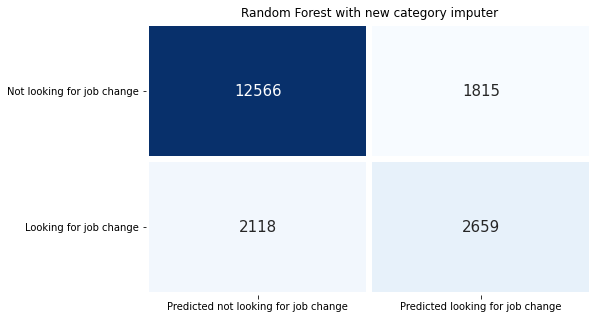

F1 score: 0.575


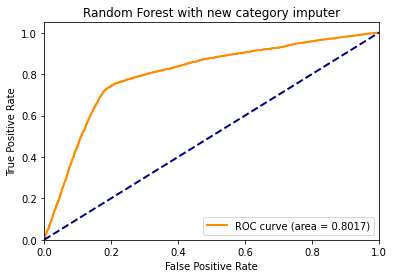

In [90]:
rf_newcat = cross_val_predict(pipe_rf, df_newcat, target_df, cv=cv, n_jobs=-1, method="predict_proba")
y_pred = np.where(rf_newcat[:,1] > 0.5, 1, 0)
custom_confusion_matrix(target_df.values, y_pred, title="Random Forest with new category imputer")
print('F1 score: {0:.3f}'.format(f1_score(target_df.values, y_pred)))
custom_roc(target_df.values, rf_newcat[:,1], title= 'Random Forest with new category imputer')

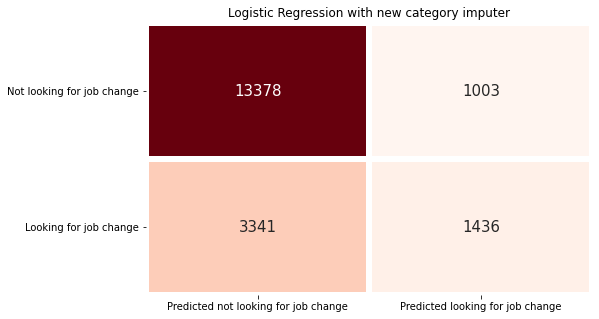

F1 score: 0.398


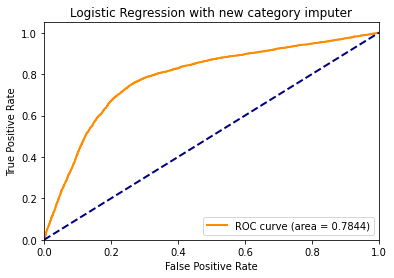

In [105]:
logreg_newcat = cross_val_predict(pipe_logreg, df_newcat, target_df, cv=cv, n_jobs=-1, method="predict_proba")
y_pred = np.where(logreg_newcat[:,1] > 0.5, 1, 0)
custom_confusion_matrix(target_df.values, y_pred, title="Logistic Regression with new category imputer", palette="Reds")
print('F1 score: {0:.3f}'.format(f1_score(target_df.values, y_pred)))
custom_roc(target_df.values, logreg_newcat[:,1], title= "Logistic Regression with new category imputer")

## F-2. Imputation with most frequent value

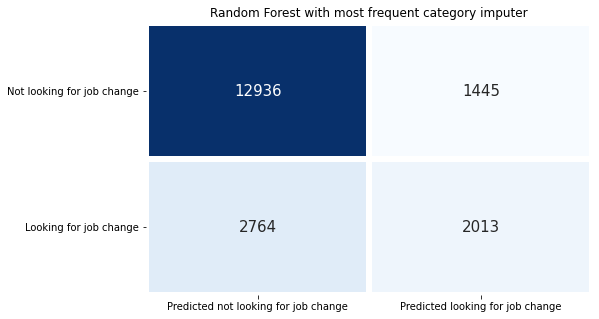

F1 score: 0.489


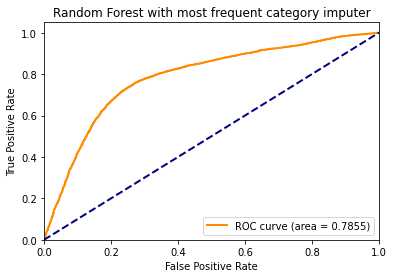

In [93]:
rf_freq = cross_val_predict(pipe_rf, df_freq, target_df, cv=cv, n_jobs=-1, method="predict_proba")
y_pred = np.where(rf_freq[:,1] > 0.5, 1, 0)
custom_confusion_matrix(target_df.values, y_pred, title="Random Forest with most frequent category imputer")
print('F1 score: {0:.3f}'.format(f1_score(target_df.values, y_pred)))
custom_roc(target_df.values, rf_freq[:,1], title= "Random Forest with most frequent category imputer")

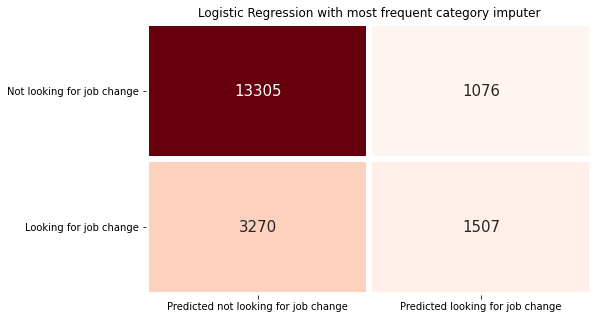

F1 score: 0.410


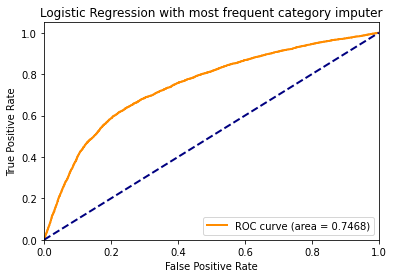

In [94]:
logreg_freq = cross_val_predict(pipe_logreg, df_freq, target_df, cv=cv, n_jobs=-1, method="predict_proba")
y_pred = np.where(logreg_freq[:,1] > 0.5, 1, 0)
custom_confusion_matrix(target_df.values, y_pred, title="Logistic Regression with most frequent category imputer", palette="Reds")
print('F1 score: {0:.3f}'.format(f1_score(target_df.values, y_pred)))
custom_roc(target_df.values, logreg_freq[:,1], title= "Logistic Regression with most frequent category imputer")

## F-3. Missing values dropout

In [95]:
target_dropout = target_df.iloc[df_dropout.index]

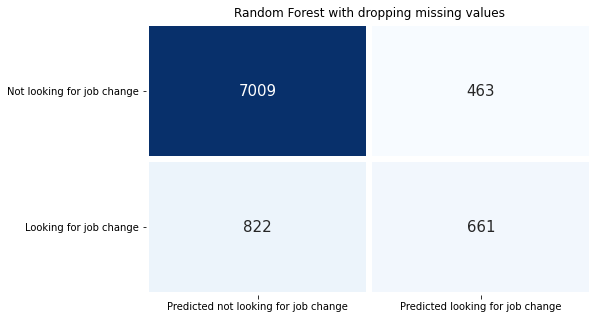

F1 score: 0.507


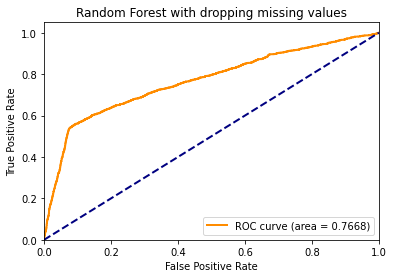

In [98]:
rf_dropout = cross_val_predict(pipe_rf, df_dropout, target_dropout, cv=cv, n_jobs=-1, method="predict_proba")
y_pred = np.where(rf_dropout[:,1] > 0.5, 1, 0)
custom_confusion_matrix(target_dropout.values, y_pred, title="Random Forest with dropping missing values")
print('F1 score: {0:.3f}'.format(f1_score(target_dropout.values, y_pred)))
custom_roc(target_dropout.values, rf_dropout[:,1], title= "Random Forest with dropping missing values")

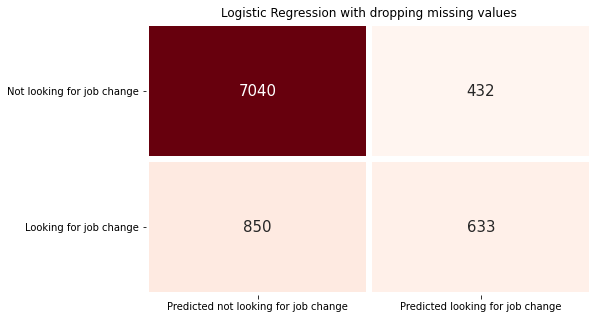

F1 score: 0.497


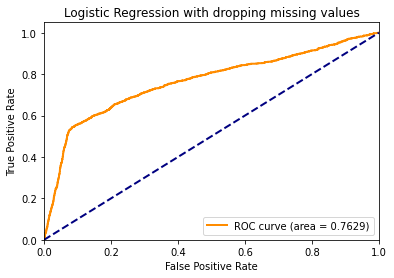

In [99]:
logreg_dropout = cross_val_predict(pipe_logreg, df_dropout, target_dropout, cv=cv, n_jobs=-1, method="predict_proba")
y_pred = np.where(logreg_dropout[:,1] > 0.5, 1, 0)
custom_confusion_matrix(target_dropout.values, y_pred, title="Logistic Regression with dropping missing values", palette="Reds")
print('F1 score: {0:.3f}'.format(f1_score(target_dropout.values, y_pred)))
custom_roc(target_dropout.values, logreg_dropout[:,1], title= "Logistic Regression with dropping missing values")

## F-4. Imputation with KNN

In [100]:
df_knn = df_knn[['education_level', 'experience', 'company_size', 'last_new_job', # Ordinal columns already encoded
              'training_hours', 'city_development_index', # Numerical columns
              'city', #categorical column with labels
              'gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']] #Categorical non-ordinal columns to be re-encoded

In [101]:
#Instantiating the categorical encoders
# The transformer is forced pipe dense matrices althrough to avoid compatibility problems with minmaxscaler afterwards
oneHotEnc_knn = OneHotEncoder() #Creating the ColumnTransformer for categorical encoding
encoderTransformer_knn = ColumnTransformer([('oneHotEnc', oneHotEnc, [7,8,9,10,11])], remainder='passthrough', sparse_threshold=0)
minmax_knn = MinMaxScaler()

In [102]:
pipe_rf_knn = Pipeline(steps=[('encoding', encoderTransformer_knn), ('scaler', minmax_knn), ('model', ranfor)])
pipe_logreg_knn = Pipeline(steps=[('encoding', encoderTransformer_knn), ('scaler', minmax_knn), ('model', logreg)])
cv = KFold(n_splits=10, shuffle=True, random_state=10)

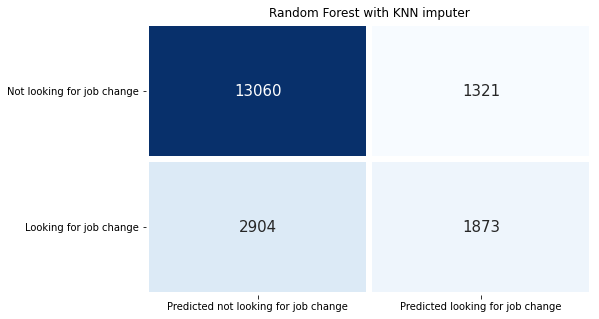

F1 score: 0.470


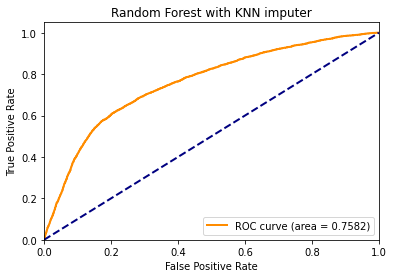

In [103]:
rf_knn = cross_val_predict(pipe_rf_knn, df_knn, target_df, cv=cv, n_jobs=-1, method="predict_proba")
y_pred = np.where(rf_knn[:,1] > 0.5, 1, 0)
custom_confusion_matrix(target_df.values, y_pred, title="Random Forest with KNN imputer")
print('F1 score: {0:.3f}'.format(f1_score(target_df.values, y_pred)))
custom_roc(target_df.values, rf_knn[:,1], title= "Random Forest with KNN imputer")

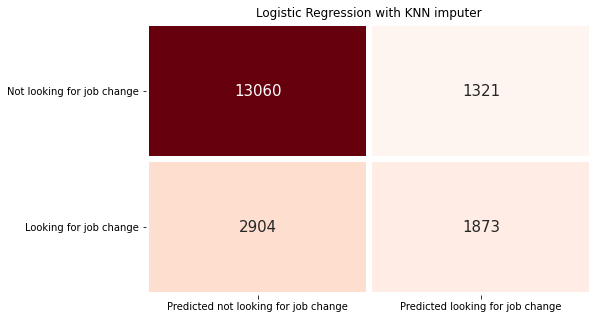

F1 score: 0.470


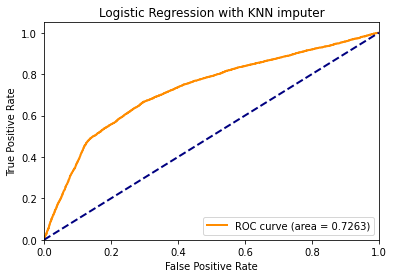

In [104]:
logreg_knn = cross_val_predict(pipe_logreg_knn, df_knn, target_df, cv=cv, n_jobs=-1, method="predict_proba")
y_pred = np.where(rf_knn[:,1] > 0.5, 1, 0)
custom_confusion_matrix(target_df.values, y_pred, title="Logistic Regression with KNN imputer", palette="Reds")
print('F1 score: {0:.3f}'.format(f1_score(target_df.values, y_pred)))
custom_roc(target_df.values, logreg_knn[:,1], title= "Logistic Regression with KNN imputer")

## Evaluation

* The best performing imputation strategy was the imputation with a new category, being the random forest algorithm the one achieving the best reulsts measured by the auc and F1 scores. This was done by obtaining the highest number of true positives (TP), even while it did not achieve the highest number of true negatives (TN).

* It is worth mentioning that random forest consistently outperformed the logistic regression, and that a naive method like imputing most frequent value slightly outperformed the imputation with KNN.

# G. Evaluation with test data

The answers for the un-labeled test data are also provided in the Kaggle link, allowing us to evaluate how the different models would have performed in the competition. 

In [107]:
test_target = np.load("jobchange_test_target_values.npy")
df_test = pd.read_csv(filepath_or_buffer='aug_test.csv')
df_test.drop(['enrollee_id'], inplace=True, axis=1)
df_test = df_test[['education_level', 'experience', 'company_size', 'last_new_job', # Ordinal columns 
              'training_hours', 'city_development_index', # Numerical columns
              'city', #categorical column to be labelled
              'gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']] #Categorical non-ordinal columns

In [108]:
df_test.head()

,education_level,experience,company_size,last_new_job,training_hours,city_development_index,city,gender,relevent_experience,enrolled_university,major_discipline,company_type
0,Graduate,9,<10,1,21,0.827,city_41,Male,Has relevent experience,Full time course,STEM,NaN
1,Graduate,5,NaN,1,98,0.920,city_103,Female,Has relevent experience,no_enrollment,STEM,Pvt Ltd
2,High School,<1,NaN,never,15,0.624,city_21,Male,No relevent experience,no_enrollment,NaN,Pvt Ltd
3,Masters,11,10/49,1,39,0.827,city_13,Male,Has relevent experience,no_enrollment,STEM,Pvt Ltd
4,Graduate,>20,10000+,>4,72,0.920,city_103,Male,Has relevent experience,no_enrollment,STEM,Pvt Ltd


In [109]:
df_test.isna().sum()

education_level            52
experience                  5
company_size              622
last_new_job               40
training_hours              0
city_development_index      0
city                        0
gender                    508
relevent_experience         0
enrolled_university        31
major_discipline          312
company_type              634
dtype: int64

In [116]:
#Impute with most frequent class
test_freq = df_test.fillna(df_test.mode().iloc[0])
#Impute with new category
test_newcat = df_test.fillna(value="missing")
#Impute with KNN
test_pre_knn = custom_encoding(df_test)
cities_series = test_pre_knn['city']
test_impute_knn = test_pre_knn.loc[:,set(test_pre_knn.columns) - set(["city"])]
#k-Nearest Neighbour Imputation
X = knn_imputer.fit_transform(test_impute_knn.values)
test_impute_knn = pd.DataFrame(X, columns = test_impute_knn.columns)
test_knn = pd.concat([cities_series, test_impute_knn], axis=1)
test_knn.columns = ['city'] + test_impute_knn.columns.tolist()
test_knn = test_knn[['education_level', 'experience', 'company_size', 'last_new_job', # Ordinal columns 
              'training_hours', 'city_development_index', # Numerical columns
              'city', #categorical column to be labelled
              'gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']]

## G-1. Imputation with new category

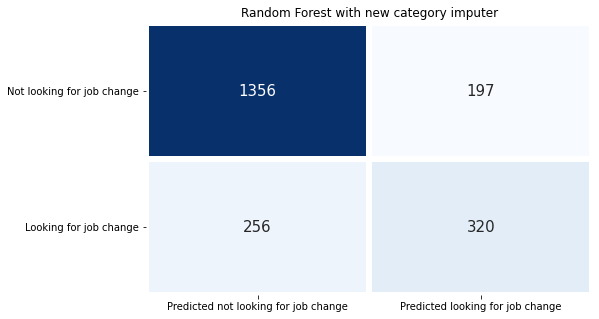

F1 score: 0.586


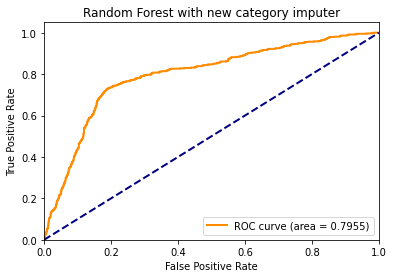

In [113]:
rf_model = pipe_rf.fit(df_newcat.values, y=target_df.values)
newcat_pred = rf_model.predict_proba(test_newcat)
y_pred = np.where(newcat_pred[:,1] > 0.5, 1, 0)
custom_confusion_matrix(test_target, y_pred, title="Random Forest with new category imputer")

print('F1 score: {0:.3f}'.format(f1_score(test_target, y_pred)))
custom_roc(test_target, newcat_pred[:,1], title= 'Random Forest with new category imputer')

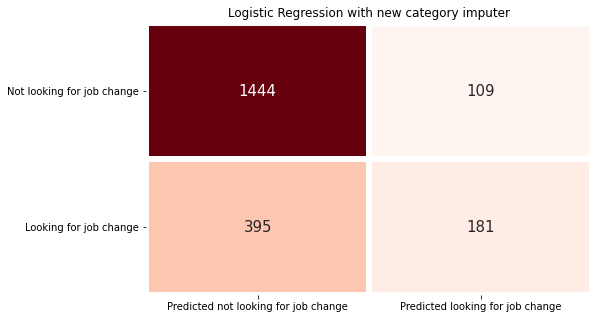

F1 score: 0.418


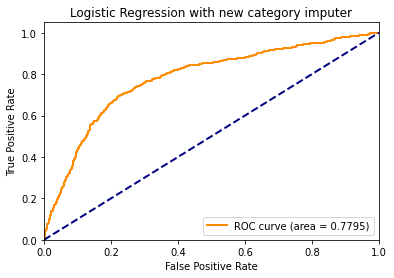

In [128]:
logreg_model = pipe_logreg.fit(df_newcat.values, y=target_df.values)
newcat_pred = logreg_model.predict_proba(test_newcat)
y_pred = np.where(newcat_pred[:,1] > 0.5, 1, 0)
custom_confusion_matrix(test_target, y_pred, title="Logistic Regression with new category imputer", palette="Reds")
print('F1 score: {0:.3f}'.format(f1_score(test_target, y_pred)))
custom_roc(test_target, newcat_pred[:,1], title= "Logistic Regression with new category imputer")

## G-2. Imputation with most frequent value

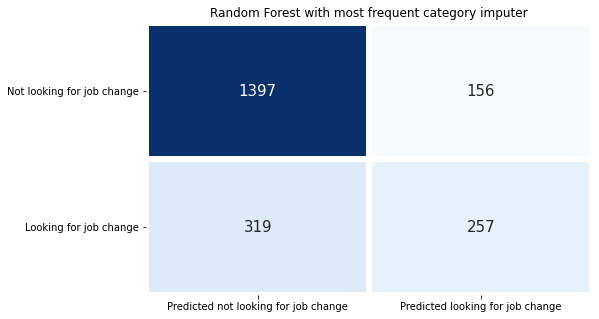

F1 score: 0.520


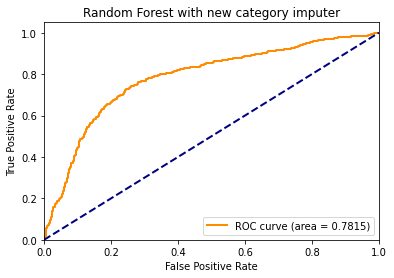

In [114]:
rf_model = pipe_rf.fit(df_freq.values, y=target_df.values)
freq_pred = rf_model.predict_proba(test_freq)
y_pred = np.where(freq_pred[:,1] > 0.5, 1, 0)
custom_confusion_matrix(test_target, y_pred, title="Random Forest with most frequent category imputer")
print('F1 score: {0:.3f}'.format(f1_score(test_target, y_pred)))
custom_roc(test_target, freq_pred[:,1], title= 'Random Forest with most frequent category imputer')

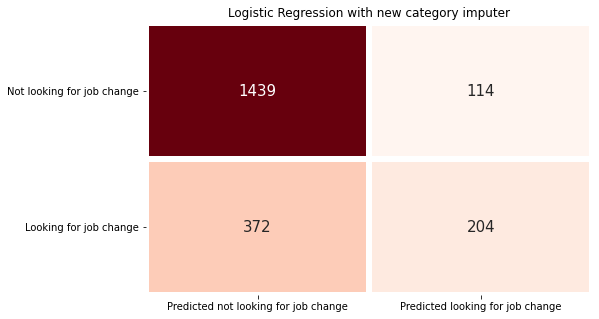

F1 score: 0.456


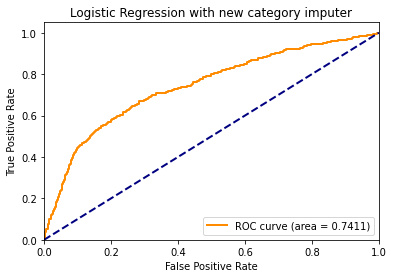

In [129]:
logreg_model = pipe_logreg.fit(df_freq.values, y=target_df.values)
freq_pred = logreg_model.predict_proba(test_freq)
y_pred = np.where(freq_pred[:,1] > 0.5, 1, 0)
custom_confusion_matrix(test_target, y_pred, title="Logistic Regression with new category imputer", palette="Reds")
print('F1 score: {0:.3f}'.format(f1_score(test_target, y_pred)))
custom_roc(test_target, freq_pred[:,1], title= "Logistic Regression with new category imputer")

## G-3. Missing values dropout

Since we cannot dropout the rows with missing values in the test set (we need it all!), the test set imputed with the most frequent class will be used in the prediciton step. This is due to the fact that the "missing" class introduced during the imputation with new category is not present in the dropout treated train set.

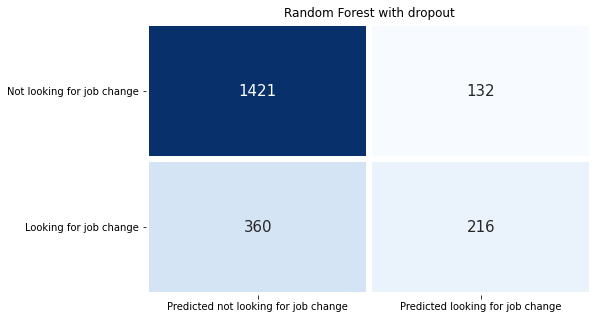

F1 score: 0.468


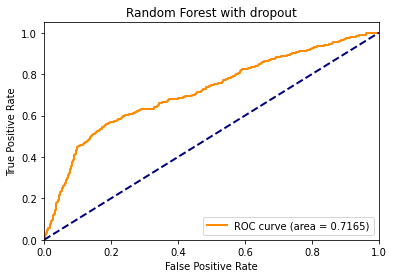

In [120]:
rf_model = pipe_rf.fit(df_dropout.values, y=target_dropout.values)
dropout_pred = rf_model.predict_proba(test_freq)
y_pred = np.where(dropout_pred[:,1] > 0.5, 1, 0)
custom_confusion_matrix(test_target, y_pred, title="Random Forest with dropout")
print('F1 score: {0:.3f}'.format(f1_score(test_target, y_pred)))
custom_roc(test_target, dropout_pred[:,1], title= 'Random Forest with dropout')

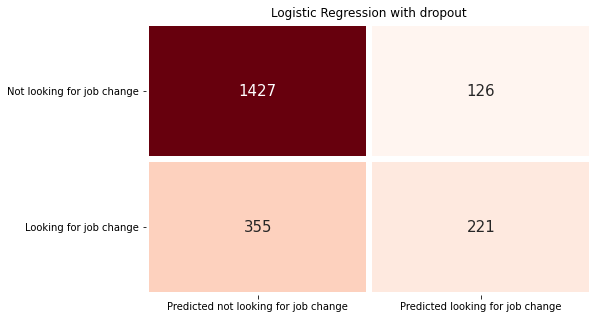

F1 score: 0.479


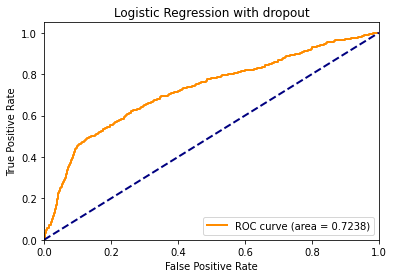

In [132]:
logreg_model = pipe_logreg.fit(df_dropout.values, y=target_dropout.values)
dropout_pred = logreg_model.predict_proba(test_freq)
y_pred = np.where(dropout_pred[:,1] > 0.5, 1, 0)
custom_confusion_matrix(test_target, y_pred, title="Logistic Regression with dropout", palette="Reds")
print('F1 score: {0:.3f}'.format(f1_score(test_target, y_pred)))
custom_roc(test_target, dropout_pred[:,1], title= "Logistic Regression with dropout")

## G-4. Imputation with KNN

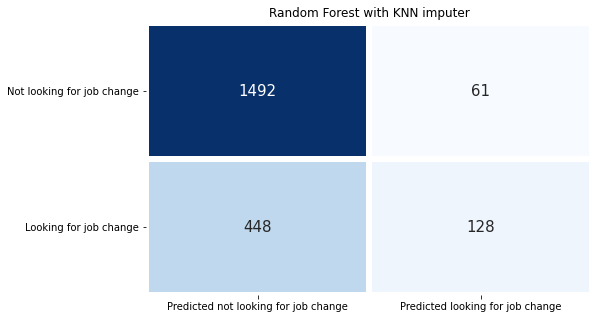

F1 score: 0.335


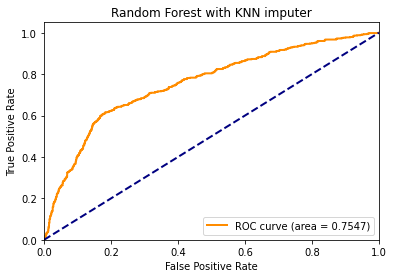

In [122]:
rf_model = pipe_rf_knn.fit(df_knn.values, y=target_df.values)
knn_pred = rf_model.predict_proba(test_knn.values)
y_pred = np.where(knn_pred[:,1] > 0.5, 1, 0)
custom_confusion_matrix(test_target, y_pred, title="Random Forest with KNN imputer")
print('F1 score: {0:.3f}'.format(f1_score(test_target, y_pred)))
custom_roc(test_target, knn_pred[:,1], title= 'Random Forest with KNN imputer')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


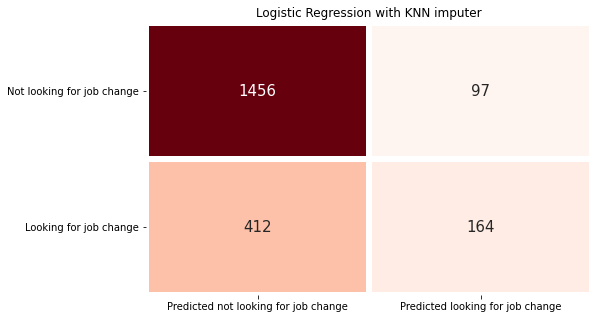

F1 score: 0.392


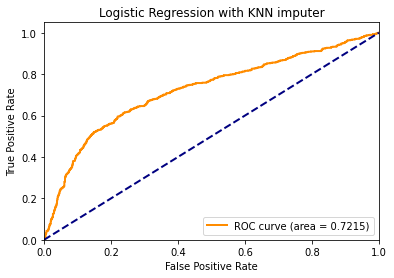

In [135]:
logreg_model = pipe_logreg_knn.fit(df_knn.values, y=target_df.values)
knn_pred = logreg_model.predict_proba(test_knn.values)
y_pred = np.where(knn_pred[:,1] > 0.5, 1, 0)
custom_confusion_matrix(test_target, y_pred, title="Logistic Regression with KNN imputer", palette="Reds")
print('F1 score: {0:.3f}'.format(f1_score(test_target, y_pred)))
custom_roc(test_target, knn_pred[:,1], title= 'Logistic Regression with KNN imputer')

## Summary and conclusion

THe table below summarizes the scores achieved for all the combinations between the imputation methods and the RF or LogReg classification.


Imputation Method | Class Method | AUC | F1 Score
--- |--- | --- | ---
New Category | RF |0.586 | 0.800
 | LogReg | 0.418 | 0.780
Most frequent Category | RF | 0.520 | 0.782 
 | LogReg | 0.456 | 0.741
MV Dropout | RF | 0.468 | 0.717
 | LogReg | 0.479 | 0.724 
KNN | RF | 0.335 | 0.758
 | LogReg | 0.390 | 0.722 

* As it can be seen, as when scoring the training data with cross-validation, the new category with RF is still the best performing combination. 

* Only with dropout the logistic regression performs better than RF (probably because the hyperparameters were optimised with the whole dataset without the dropout, meaning many more observations performing better with deeper trees). 

* The imputation with KNN failed to beat even the naive approach of imputation with most frequent category. It scoring particularly low in the ROC AUC, implying a low separability of job seekers and satisfied workers by the probabilities predicted.

* The handling of missing values is a critical step for the performance of the model. An even better solution was likely achievable with combining the different methods tried